In [ ]:
import os
import random
import shutil

from multiprocessing.dummy import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
import joblib

from skimage.morphology import binary_opening, disk, label

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

In [ ]:
!pip install opendatasets --quiet
!pip install ultralytics

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.0/1.0 MB 42.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚

In [ ]:
import opendatasets as od
import pandas as pd

od.download("https://www.kaggle.com/competitions/where-are-the-seagulls/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rponomarev
Your Kaggle Key: ¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑¬∑


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 36.7M/36.7M [00:00<00:00, 1.09GB/s]


Extracting archive ./where-are-the-seagulls/where-are-the-seagulls.zip to ./where-are-the-seagulls


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import os

model_my = YOLO('yolo11n.pt')
# result = model(["/content/where-are-the-seagulls/data/test/images/20200929_161236_01_JPG.rf.6e9bbc6fa8cc4ad9ad4d94b348e693bb.jpg"])
res = model_my.train(data='youla_config.yaml',epochs=100,imgsz=720)

New https://pypi.org/project/ultralytics/8.3.153 available üòÉ Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 üöÄ Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=youla_config.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=720, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train8, nbs=64, nms=False, opset=None, optimize=False, 

train: Scanning /content/where-are-the-seagulls/data/train/labels.cache... 500 images, 32 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:00<?, ?it/s]

train: /content/where-are-the-seagulls/data/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5.jpg: 2 duplicate labels removed
train: /content/where-are-the-seagulls/data/train/images/20200819_182328_01_JPG.rf.cca24be539aa73a24a2bf112ab67fe68.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/data/train/images/20200910_185837_01_JPG.rf.cdf85cd8e98797d94fb93d972d58fc5f.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/data/train/images/20200913_121758_01_JPG.rf.126b4bd798cd834f2c08f1c85a6fee70.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/data/train/images/20200913_171925_01_JPG.rf.de1d151832416a3f2df30dcdbf84bf8a.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/data/train/images/20200924_183741_01_JPG.rf.cbc768e717616cc48643dba4f3a76bbd.jpg: 3 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='w

val: Fast image access ‚úÖ (ping: 0.0¬±0.0 ms, read: 384.8¬±360.0 MB/s, size: 85.4 KB)


val: Scanning /content/where-are-the-seagulls/data/train/labels.cache... 500 images, 32 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 500/500 [00:00<?, ?it/s]

train: /content/where-are-the-seagulls/data/train/images/20200816_180222_01_JPG.rf.5f3bc87ff01f17b2a00c3ecf18d14ac5.jpg: 2 duplicate labels removed
train: /content/where-are-the-seagulls/data/train/images/20200819_182328_01_JPG.rf.cca24be539aa73a24a2bf112ab67fe68.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/data/train/images/20200910_185837_01_JPG.rf.cdf85cd8e98797d94fb93d972d58fc5f.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/data/train/images/20200913_121758_01_JPG.rf.126b4bd798cd834f2c08f1c85a6fee70.jpg: 1 duplicate labels removed
train: /content/where-are-the-seagulls/data/train/images/20200913_171925_01_JPG.rf.de1d151832416a3f2df30dcdbf84bf8a.jpg: 3 duplicate labels removed
train: /content/where-are-the-seagulls/data/train/images/20200924_183741_01_JPG.rf.cbc768e717616cc48643dba4f3a76bbd.jpg: 3 duplicate labels removed


Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 736 train, 736 val
Using 2 dataloader workers
Logging results to runs/detect/train8
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.32G      2.319      2.587      1.169         71        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:13<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.46it/s]


                   all        500       5373     0.0124      0.347     0.0171    0.00714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.56G      2.146      1.631      1.156         33        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:07<00:00,  2.25it/s]

                   all        500       5373     0.0138      0.384       0.25     0.0816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.56G      2.084      1.501      1.144         69        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.32it/s]

                   all        500       5373      0.632      0.507      0.542      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.56G      2.081      1.414       1.12         55        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.57it/s]

                   all        500       5373      0.666       0.61       0.64      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.56G      2.056      1.349      1.133         63        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.32it/s]

                   all        500       5373       0.75      0.703      0.754      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.56G      2.005      1.273      1.102         81        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.78it/s]

                   all        500       5373      0.783      0.734      0.793      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.56G      1.988      1.239      1.114         81        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.35it/s]

                   all        500       5373      0.767      0.698      0.767      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.56G      1.975      1.245       1.12         79        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.32it/s]

                   all        500       5373      0.769       0.72      0.787      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.56G      1.963      1.196       1.11         47        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.34it/s]

                   all        500       5373      0.776      0.705      0.765      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.56G      1.977      1.207       1.11         37        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.82it/s]


                   all        500       5373      0.784      0.694      0.777      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.57G       1.95       1.18      1.103        111        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.36it/s]

                   all        500       5373      0.818      0.729       0.81      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.57G      1.956      1.156      1.102         71        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.93it/s]

                   all        500       5373      0.809      0.717      0.807      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.58G      1.962      1.134      1.092         97        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.45it/s]

                   all        500       5373       0.81      0.732       0.82      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       3.6G      1.911      1.094      1.075         72        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:13<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.81it/s]

                   all        500       5373      0.823       0.76      0.842      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       3.6G      1.932        1.1      1.092         49        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:07<00:00,  2.28it/s]

                   all        500       5373      0.807      0.768      0.823      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       3.6G      1.908      1.099      1.091         51        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.87it/s]


                   all        500       5373        0.8      0.747      0.817      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       3.6G      1.924      1.092      1.084         48        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:07<00:00,  2.17it/s]

                   all        500       5373      0.824      0.745       0.83       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       3.6G      1.896      1.073      1.081         42        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.83it/s]


                   all        500       5373       0.83       0.74       0.83      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       3.6G      1.894      1.044      1.094         43        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.48it/s]

                   all        500       5373      0.817      0.748      0.832      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       3.6G      1.898      1.046      1.083         74        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.68it/s]


                   all        500       5373      0.833      0.747      0.827      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       3.6G      1.948       1.08      1.109         60        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.53it/s]

                   all        500       5373      0.838      0.762      0.842      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100       3.6G      1.878      1.049      1.071         49        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.55it/s]

                   all        500       5373      0.841      0.775      0.852      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100       3.6G      1.904      1.022      1.074         44        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.50it/s]

                   all        500       5373      0.841      0.783      0.857      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       3.6G      1.846     0.9983      1.065         58        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.53it/s]


                   all        500       5373      0.827      0.781      0.852        0.4

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100       3.6G       1.86     0.9904      1.073         71        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.81it/s]

                   all        500       5373      0.826      0.758      0.844       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       3.6G      1.872      1.011       1.06         29        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.46it/s]

                   all        500       5373       0.86      0.783      0.864      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       3.6G      1.844     0.9978      1.068        125        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  3.01it/s]

                   all        500       5373       0.85      0.774      0.862       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       3.6G      1.845     0.9965      1.069         50        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.46it/s]

                   all        500       5373      0.865      0.784      0.869       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       3.6G      1.838      0.981       1.07         34        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.80it/s]

                   all        500       5373      0.833      0.751      0.843      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       3.6G      1.861     0.9926       1.07         61        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.38it/s]

                   all        500       5373      0.851      0.783      0.863      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       3.6G      1.821     0.9664      1.051         44        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.90it/s]

                   all        500       5373      0.833      0.795      0.865      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100       3.6G      1.837     0.9967       1.06         31        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.45it/s]


                   all        500       5373      0.853      0.768      0.847      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       3.6G      1.878     0.9876      1.074         53        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.96it/s]


                   all        500       5373       0.87      0.794      0.876      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100       3.6G      1.816     0.9615      1.062         79        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.40it/s]

                   all        500       5373       0.87       0.81      0.885      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       3.6G      1.809      0.956      1.052         76        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.71it/s]

                   all        500       5373      0.849      0.809      0.883      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       3.6G      1.789      0.932       1.05         81        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.66it/s]

                   all        500       5373       0.87      0.801      0.882      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       3.6G      1.816     0.9633      1.046         65        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.66it/s]

                   all        500       5373      0.855      0.795       0.88      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100       3.6G      1.798     0.9394       1.04         59        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.93it/s]

                   all        500       5373      0.868      0.824      0.893       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       3.6G      1.812     0.9292      1.058         50        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.30it/s]

                   all        500       5373      0.853      0.806      0.882      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       3.6G      1.838     0.9704      1.067         40        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.94it/s]

                   all        500       5373      0.862      0.814      0.888      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       3.6G      1.799     0.9572      1.043         44        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.30it/s]


                   all        500       5373      0.869       0.81      0.891      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100       3.6G      1.799     0.9425      1.049         34        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.91it/s]

                   all        500       5373      0.855      0.822      0.892      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100       3.6G      1.799      0.939      1.038         85        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.44it/s]

                   all        500       5373      0.873      0.817      0.887      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100       3.6G      1.796     0.9184      1.047         87        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.85it/s]

                   all        500       5373      0.874      0.813      0.894      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       3.6G      1.807     0.9387      1.059         45        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.34it/s]

                   all        500       5373      0.875      0.792      0.876      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       3.6G      1.809     0.9419      1.059         23        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.60it/s]

                   all        500       5373      0.876      0.821      0.898      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       3.6G      1.796     0.9251      1.044         51        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.44it/s]

                   all        500       5373      0.863      0.824      0.895      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       3.6G      1.789     0.9103      1.027        124        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.98it/s]

                   all        500       5373      0.881      0.823      0.902      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100       3.6G      1.767     0.9059      1.034         36        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.46it/s]


                   all        500       5373      0.867        0.8       0.89       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100       3.6G      1.779     0.9082      1.038         67        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.96it/s]

                   all        500       5373      0.878      0.823      0.904      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100       3.6G      1.766     0.8971       1.04         44        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.46it/s]

                   all        500       5373      0.887      0.831      0.905      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100       3.6G      1.741     0.8796      1.035         47        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.82it/s]

                   all        500       5373       0.89      0.823      0.905      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       3.6G      1.749     0.8942      1.032         70        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.36it/s]

                   all        500       5373      0.871      0.834      0.896      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100       3.6G      1.734     0.8698      1.052         58        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.64it/s]


                   all        500       5373      0.872      0.835      0.903      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100       3.6G      1.752     0.8722      1.034         93        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.84it/s]

                   all        500       5373      0.883       0.83      0.906      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       3.6G      1.758     0.8948      1.036         37        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.39it/s]

                   all        500       5373      0.893      0.836      0.907       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       3.6G      1.754     0.8785      1.031         68        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.91it/s]

                   all        500       5373      0.889      0.837      0.911      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       3.6G      1.737     0.8818      1.032         37        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.42it/s]

                   all        500       5373      0.884      0.835      0.909      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       3.6G      1.791     0.9153      1.046         80        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.94it/s]

                   all        500       5373      0.889      0.839      0.911      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       3.6G      1.745     0.8836      1.045         42        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.31it/s]

                   all        500       5373      0.867      0.843      0.906      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100       3.6G      1.727     0.8728      1.025         47        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  3.00it/s]

                   all        500       5373      0.892      0.843      0.907      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100       3.6G      1.765     0.8821      1.031         42        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.42it/s]

                   all        500       5373      0.884      0.849      0.919      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100       3.6G      1.715     0.8634      1.029         29        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.99it/s]


                   all        500       5373      0.888      0.848      0.916      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       3.6G       1.75     0.8773      1.039         30        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.50it/s]

                   all        500       5373      0.893      0.842      0.914      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100       3.6G      1.714     0.8741      1.019         30        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.71it/s]

                   all        500       5373      0.886      0.847      0.917      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100       3.6G      1.721     0.8694      1.034         48        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.48it/s]

                   all        500       5373      0.891      0.859      0.918      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100       3.6G      1.735     0.8711      1.025         39        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.71it/s]


                   all        500       5373      0.895      0.845      0.919      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100       3.6G      1.714     0.8472      1.014         44        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.67it/s]

                   all        500       5373      0.896      0.852      0.921      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100       3.6G      1.692     0.8481      1.017         12        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.45it/s]

                   all        500       5373      0.892      0.857       0.92      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       3.6G        1.7     0.8374       1.02         65        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.80it/s]

                   all        500       5373      0.897      0.844      0.915      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100       3.6G      1.725     0.8485      1.022         84        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.29it/s]

                   all        500       5373      0.892      0.858      0.922      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       3.6G      1.713     0.8504      1.034         51        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.71it/s]

                   all        500       5373      0.896      0.858      0.922       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       3.6G      1.705     0.8391      1.025         34        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.46it/s]


                   all        500       5373      0.878       0.86       0.92       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100       3.6G      1.667     0.8197      1.011         63        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.84it/s]

                   all        500       5373      0.896      0.864      0.925      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       3.6G      1.682     0.8288      1.007         71        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.41it/s]

                   all        500       5373      0.892      0.856      0.922      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       3.6G      1.672     0.8256       1.01         42        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.83it/s]


                   all        500       5373      0.902      0.858      0.923       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100       3.6G       1.68     0.8327      1.017         69        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:07<00:00,  2.14it/s]

                   all        500       5373      0.894      0.865      0.925      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100       3.6G       1.68     0.8156      1.001         89        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.84it/s]

                   all        500       5373      0.884      0.869      0.925      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.84G      1.698     0.8257       1.01        113        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.34it/s]

                   all        500       5373        0.9      0.846       0.92      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.84G      1.678     0.8191      1.024         40        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.86it/s]

                   all        500       5373        0.9      0.863      0.928      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.84G      1.673      0.818      1.007         59        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.40it/s]


                   all        500       5373      0.899      0.856      0.924      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.84G      1.659     0.8105      1.012         72        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.65it/s]

                   all        500       5373      0.899      0.867      0.926      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.84G      1.642     0.7961      1.003         43        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.45it/s]

                   all        500       5373      0.898      0.863      0.931      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.84G      1.649     0.8034      1.008         24        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  3.05it/s]

                   all        500       5373      0.907       0.87      0.932      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.84G      1.674     0.8097      1.003         59        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.35it/s]

                   all        500       5373      0.908       0.87      0.932      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.84G       1.66      0.808      1.014        130        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.90it/s]

                   all        500       5373      0.907      0.877      0.931      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.84G      1.672     0.8142      1.012         88        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.50it/s]

                   all        500       5373      0.903      0.867      0.928      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.84G      1.678     0.8246      1.017         38        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:12<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.81it/s]

                   all        500       5373      0.907      0.868      0.934      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.84G       1.64     0.7969       1.01         86        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.38it/s]

                   all        500       5373      0.902      0.874      0.935      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.84G      1.645     0.7926      1.011         77        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.68it/s]


                   all        500       5373      0.909      0.874      0.935      0.509
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.84G      1.638     0.7777      1.058         40        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:13<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.54it/s]

                   all        500       5373      0.901      0.871      0.933      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.84G      1.625     0.7876      1.035         81        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:10<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.68it/s]

                   all        500       5373       0.91      0.866      0.934       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.84G      1.642     0.7844      1.051         98        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  3.08it/s]

                   all        500       5373      0.904      0.876      0.937       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.84G      1.609      0.768      1.035         55        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.58it/s]


                   all        500       5373       0.91      0.879      0.937      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.84G      1.594     0.7648      1.023         35        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.99it/s]

                   all        500       5373       0.91      0.874      0.936      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.84G      1.603      0.762       1.03         40        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.86it/s]

                   all        500       5373      0.913      0.878      0.939      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.84G      1.602     0.7642      1.036         44        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:10<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.56it/s]

                   all        500       5373      0.913      0.875      0.938      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.84G      1.597     0.7577       1.03         27        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:05<00:00,  2.92it/s]

                   all        500       5373      0.916      0.874      0.939       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.84G      1.606      0.754      1.039         47        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.56it/s]

                   all        500       5373      0.915      0.873      0.939      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.84G      1.592     0.7594      1.032         29        736: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 32/32 [00:10<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:06<00:00,  2.59it/s]

                   all        500       5373      0.912      0.878       0.94      0.521



100 epochs completed in 0.530 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 5.5MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics 8.3.152 üöÄ Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:09<00:00,  1.66it/s]


                   all        500       5373      0.912      0.877       0.94      0.521
Speed: 0.5ms preprocess, 3.2ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/train8


In [ ]:
result = model_my.predict(["/content/where-are-the-seagulls/data/test/images/20201005_175548_01_JPG.rf.70f27473f47ffe9e776dbb9d0ff21b86.jpg"])
print(result)


0: 736x736 1 seagull, 8.9ms
Speed: 3.4ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 736)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'seagull'}
obb: None
orig_img: array([[[ 57,  57,  51],
        [ 60,  60,  54],
        [ 65,  64,  60],
        ...,
        [185, 176, 172],
        [184, 175, 171],
        [184, 175, 171]],

       [[ 57,  57,  51],
        [ 60,  60,  54],
        [ 65,  64,  60],
        ...,
        [184, 175, 171],
        [184, 175, 171],
        [184, 175, 171]],

       [[ 56,  56,  50],
        [ 60,  60,  54],
        [ 64,  63,  59],
        ...,
        [184, 175, 171],
        [183, 174, 170],
        [183, 174, 170]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 20,  35,  31],
        [ 32,  47,  43],
        [ 45,  60,  56]],

       [[  0,   0,   0],

In [ ]:
result[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.6837], device='cuda:0')
data: tensor([[241.0286, 415.5958, 252.4627, 431.5237,   0.6837,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 640)
shape: torch.Size([1, 6])
xywh: tensor([[246.7456, 423.5598,  11.4341,  15.9279]], device='cuda:0')
xywhn: tensor([[0.3855, 0.6618, 0.0179, 0.0249]], device='cuda:0')
xyxy: tensor([[241.0286, 415.5958, 252.4627, 431.5237]], device='cuda:0')
xyxyn: tensor([[0.3766, 0.6494, 0.3945, 0.6743]], device='cuda:0')

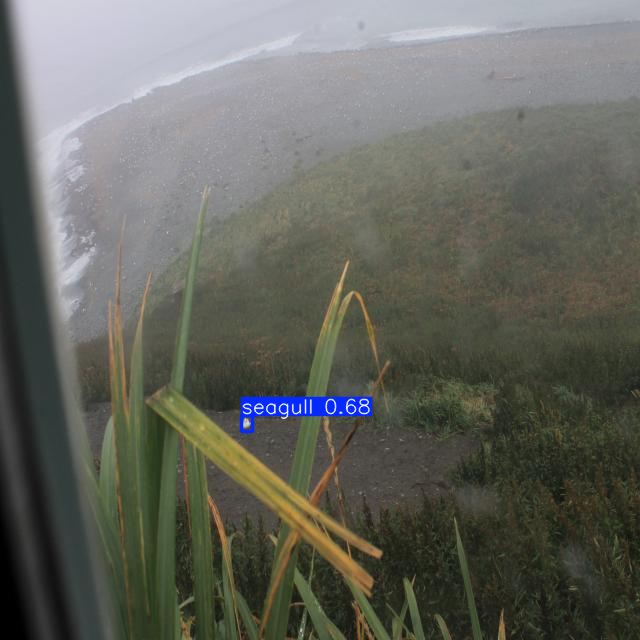

In [ ]:

result[0].show()

In [ ]:
import os
import pandas as pd

def make_dataframe(img_dir):
    data = []
    cnt = -1
    for filename in os.listdir(img_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            cnt += 1
            full_path = os.path.join(filename)
            all_path = os.path.join(img_dir, filename)
            data.append({'index': cnt,'filename': full_path, 'all_path': all_path})

    df = pd.DataFrame(data)
    return df

In [ ]:
df = make_dataframe("/content/where-are-the-seagulls/data/test/images")

df.head()

index                                           filename  \
0      0  20201007_130843_01_JPG.rf.8f442fbcd9cd5e9d02e1...   
1      1  20201006_090025_01_JPG.rf.aed12bd2aed78041950f...   
2      2  20200929_141202_01_JPG.rf.3b6082af0a88884363aa...   
3      3  20201001_182725_01_JPG.rf.c2f7e6a1e5a06fdf1bdc...   
4      4  20201011_143747_01_JPG.rf.1a8844176e2f98a7e391...   

                                            all_path  
0  /content/where-are-the-seagulls/data/test/imag...  
1  /content/where-are-the-seagulls/data/test/imag...  
2  /content/where-are-the-seagulls/data/test/imag...  
3  /content/where-are-the-seagulls/data/test/imag...  
4  /content/where-are-the-seagulls/data/test/imag...

In [ ]:
df['all_path'].values

array(['/content/where-are-the-seagulls/data/test/images/20201007_130843_01_JPG.rf.8f442fbcd9cd5e9d02e13e069ff7ec59.jpg', '/content/where-are-the-seagulls/data/test/images/20201006_090025_01_JPG.rf.aed12bd2aed78041950f8df51d0810c1.jpg',
       '/content/where-are-the-seagulls/data/test/images/20200929_141202_01_JPG.rf.3b6082af0a88884363aaa95bf76987db.jpg', '/content/where-are-the-seagulls/data/test/images/20201001_182725_01_JPG.rf.c2f7e6a1e5a06fdf1bdc854046575487.jpg',
       '/content/where-are-the-seagulls/data/test/images/20201011_143747_01_JPG.rf.1a8844176e2f98a7e3912c485da71d6d.jpg', '/content/where-are-the-seagulls/data/test/images/20201009_082140_01_JPG.rf.1a92c675763355bf73efd404d842988b.jpg',
       '/content/where-are-the-seagulls/data/test/images/20201002_083142_01_JPG.rf.5e31ae3ee3975752b95b0e86857424f5.jpg', '/content/where-are-the-seagulls/data/test/images/20200928_160525_01_JPG.rf.50f3289f065a9a4f5372ffa3df9e7265.jpg',
       '/content/where-are-the-seagulls/data/test/im

In [ ]:
results = []
cnt = 0
for i in df["all_path"]:
  res = model_my.predict(i)
  d = {}
  d["index"] = cnt
  cnt += 1
  d["filename"] = '/'.join(i.split('/')[-1:])
  d["bbox"] = res[0].boxes.xywhn
  results.append(d)


image 1/1 /content/where-are-the-seagulls/data/test/images/20201007_130843_01_JPG.rf.8f442fbcd9cd5e9d02e13e069ff7ec59.jpg: 736x736 (no detections), 12.6ms
Speed: 4.3ms preprocess, 12.6ms inference, 0.9ms postprocess per image at shape (1, 3, 736, 736)

image 1/1 /content/where-are-the-seagulls/data/test/images/20201006_090025_01_JPG.rf.aed12bd2aed78041950f8df51d0810c1.jpg: 736x736 (no detections), 10.8ms
Speed: 3.6ms preprocess, 10.8ms inference, 0.7ms postprocess per image at shape (1, 3, 736, 736)

image 1/1 /content/where-are-the-seagulls/data/test/images/20200929_141202_01_JPG.rf.3b6082af0a88884363aaa95bf76987db.jpg: 736x736 3 seagulls, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 736)

image 1/1 /content/where-are-the-seagulls/data/test/images/20201001_182725_01_JPG.rf.c2f7e6a1e5a06fdf1bdc854046575487.jpg: 736x736 3 seagulls, 8.9ms
Speed: 3.2ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 736)

i

In [ ]:
results

[{'index': 0,
  'filename': '20201007_130843_01_JPG.rf.8f442fbcd9cd5e9d02e13e069ff7ec59.jpg',
  'bbox': tensor([], device='cuda:0', size=(0, 4))},
 {'index': 1,
  'filename': '20201006_090025_01_JPG.rf.aed12bd2aed78041950f8df51d0810c1.jpg',
  'bbox': tensor([], device='cuda:0', size=(0, 4))},
 {'index': 2,
  'filename': '20200929_141202_01_JPG.rf.3b6082af0a88884363aaa95bf76987db.jpg',
  'bbox': tensor([[0.5229, 0.6453, 0.0186, 0.0296],
          [0.3635, 0.6442, 0.0198, 0.0274],
          [0.1508, 0.6718, 0.0271, 0.0297]], device='cuda:0')},
 {'index': 3,
  'filename': '20201001_182725_01_JPG.rf.c2f7e6a1e5a06fdf1bdc854046575487.jpg',
  'bbox': tensor([[0.7054, 0.6864, 0.0413, 0.0476],
          [0.7730, 0.6295, 0.0328, 0.0488],
          [0.3848, 0.6580, 0.0238, 0.0291]], device='cuda:0')},
 {'index': 4,
  'filename': '20201011_143747_01_JPG.rf.1a8844176e2f98a7e3912c485da71d6d.jpg',
  'bbox': tensor([], device='cuda:0', size=(0, 4))},
 {'index': 5,
  'filename': '20201009_082140_01_JPG

In [ ]:
 df1 = pd.DataFrame(results)

In [ ]:
type(df1)

pandas.core.frame.DataFrame

In [ ]:
df1

index                                           filename  \
0       0  20201007_130843_01_JPG.rf.8f442fbcd9cd5e9d02e1...   
1       1  20201006_090025_01_JPG.rf.aed12bd2aed78041950f...   
2       2  20200929_141202_01_JPG.rf.3b6082af0a88884363aa...   
3       3  20201001_182725_01_JPG.rf.c2f7e6a1e5a06fdf1bdc...   
4       4  20201011_143747_01_JPG.rf.1a8844176e2f98a7e391...   
..    ...                                                ...   
94     94  20201008_171704_01_JPG.rf.f63c781a9916b4151a4e...   
95     95  20201010_143036_01_JPG.rf.ce49ced547214ece6903...   
96     96  20201008_101503_01_JPG.rf.65a4e2c7ee77c06cf4ae...   
97     97  20200929_111110_01_JPG.rf.edae4423a2ce95815bce...   
98     98  20201012_085146_01_JPG.rf.17b44f92fa8cfa93ea1c...   

                                                 bbox  
0                                                  []  
1                                                  []  
2   [[tensor(0.5229, device='cuda:0'), tensor(0.64...  
3   [[tensor(0.7054, device='cuda:0'), tensor(0.68...  
4                                                  []  
..                                                ...  
94                                                 []  
95                                                 []  
96                                                 []  
97  [[tensor(0.2917, device='cuda:0'), tensor(0.67...  
98                                                 []  

[99 rows x 3 columns]

In [ ]:
import torch
import numpy as np

def modify_bbox(tensor):
    if isinstance(tensor, torch.Tensor):
        if tensor.is_cuda:
            tensor = tensor.cpu()
        tensor = tensor.numpy()

    if tensor.size == 0:
        return np.array(-1)
    elif tensor.ndim == 1:
        return np.insert(tensor, 0, 0)
    elif tensor.ndim == 2:
        return np.insert(tensor, 0, 0, axis=1)
    else:
        return tensor

df1["bbox"] = df1["bbox"].apply(modify_bbox)

In [ ]:
df1

index                                           filename  \
0       0  20201007_130843_01_JPG.rf.8f442fbcd9cd5e9d02e1...   
1       1  20201006_090025_01_JPG.rf.aed12bd2aed78041950f...   
2       2  20200929_141202_01_JPG.rf.3b6082af0a88884363aa...   
3       3  20201001_182725_01_JPG.rf.c2f7e6a1e5a06fdf1bdc...   
4       4  20201011_143747_01_JPG.rf.1a8844176e2f98a7e391...   
..    ...                                                ...   
94     94  20201008_171704_01_JPG.rf.f63c781a9916b4151a4e...   
95     95  20201010_143036_01_JPG.rf.ce49ced547214ece6903...   
96     96  20201008_101503_01_JPG.rf.65a4e2c7ee77c06cf4ae...   
97     97  20200929_111110_01_JPG.rf.edae4423a2ce95815bce...   
98     98  20201012_085146_01_JPG.rf.17b44f92fa8cfa93ea1c...   

                                                 bbox  
0                                                  -1  
1                                                  -1  
2   [[0.0, 0.5228618, 0.64532596, 0.018595649, 0.0...  
3   [[0.0, 0.7053524, 0.6864404, 0.04129925, 0.047...  
4                                                  -1  
..                                                ...  
94                                                 -1  
95                                                 -1  
96                                                 -1  
97  [[0.0, 0.29171166, 0.67426825, 0.02392943, 0.0...  
98                                                 -1  

[99 rows x 3 columns]

In [ ]:
type(df1['bbox'][2])

numpy.ndarray

In [ ]:
import numpy as np
import pandas as pd

def array_to_string(arr):
    if isinstance(arr, np.ndarray):
        return ' '.join(map(str, arr.flatten()))
    elif isinstance(arr, (list, tuple)):
        return ' '.join(map(str, arr))
    return str(arr)

df_formatted = df1.applymap(array_to_string)

df_formatted.to_csv('output.csv', index=False)